Scatter plots reveal relationships between two variables X, Y when both are numeric variables.
Traditional scatter plots suffer from overdraw as the number of (Xi, Yi)   pairs increases. Overdraw makes the relationship between the two variables difficult to discern. If the number of  (Xi, Yi)   pairs is big “*the smoothed scatter plot is the desired visual display for revealing a rough-free relationship lying within big data*” __[[1]](https://www.crcpress.com/Statistical-and-Machine-Learning-Data-Mining-Techniques-for-Better-Predictive/Ratner/p/book/9781498797603)__. The following procedure can be used for constructing a smoothed scatter plot __[[1]](https://www.crcpress.com/Statistical-and-Machine-Learning-Data-Mining-Techniques-for-Better-Predictive/Ratner/p/book/9781498797603)__:

-  Plot the (X, Y) data points on X-Y graph
-  Divide X-axis into distinct nonoverlapping neighborhoods (slices). Usually the number of slices N = 10 or greater
-  Take the mean or median X within each slice (smoothed_X)
-  Take the mean or median Y within each slice (smoothed_Y)
-  Plot (smoothed_X, smoothed_Y) pairs
-  Connect the smooth points

After plotting the smoothed scatter plot we can apply  general association test (GAT) [1] to the X, Y variables. GAT procedure consists of the following steps:

-  Plot the N smoothed lines in a scatterplot and draw medial line
-  Connect the N smooth points with N - 1 lines (segments)
-  Consider the test statistic TS

where 

- **Medial line**: a horizontal line that divides the N points into equal sized groups
- **m**: the number of line segments that cross the medial line
- **H0**: there is no association between the two variables. H1: there is an association between the two variables.
- **TS**: test statistics, TS = N - 1 - m. Reject H0 if TS is equal to or greater than cutoff score in Table 3.5 [[1]](https://www.crcpress.com/Statistical-and-Machine-Learning-Data-Mining-Techniques-for-Better-Predictive/Ratner/p/book/9781498797603)

There is no simple answer to how to choose correct N value for creating smoothed scatter plots. Let’s experiment with several different datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# New dataframe consisting of two columns name_X, name_y
def extract_from_dataset(dataset, name_X, name_Y):
    return dataset[[name_X, name_Y]].copy()

#Create a dictionary containing intervals (v) and theirs number (k)
def intervals_d(df, n_slices, name_X):
    out, bins = pd.qcut(df[name_X], n_slices, retbins = True)
    intervals = [pd.Interval(left = bins[i], right = bins[i+1], closed = 'right')
                 for i in range(len(bins) - 1)]
    intervals_dict = dict(zip(range(1, len(bins)), intervals))
    return intervals_dict

# Check whether x belongs to an interval                
def set_interval(x, intervals_dict):
    for k,v in intervals_dict.items():
        if x in v:
            return k

# Smooth X and Y
def smooth(df, name_X, name_Y, intervals_dict):
    df['X_Interval'] = df[name_X].apply(lambda x: set_interval(x, intervals_dict))
    smoothed_df = df.groupby(by = 'X_Interval').apply(np.mean)[[name_X, name_Y]]
    smoothed_df = smoothed_df.reset_index()
    smoothed_df['X_Interval'] = smoothed_df['X_Interval'].astype(dtype = 'int32')
    df = df[[name_X, name_Y]]
    return smoothed_df

# Plot raw and smoothed scatterplots
def scatterplots(df, name_X, name_Y, n_slices):
    fig = plt.figure(figsize=(18, 18))
    # Raw scatterplot
    ax = fig.add_subplot(221)
    plt.grid()
    plt.scatter(df[name_X], df[name_Y])
    plt.xlabel(name_X)
    plt.ylabel(name_Y)
    plt.axis('tight')
    
    # Smoothed scatterplot
    ax = fig.add_subplot(222)
    intervals_dict = intervals_d(df, n_slices, name_X)
    smoothed_df = smooth(df, name_X, name_Y, intervals_dict)
    Xmin = smoothed_df[name_X].min()
    Xmax = smoothed_df[name_X].max()
    ymin = smoothed_df[name_Y].min()
    ymax = smoothed_df[name_Y].max()
    ymedial = smoothed_df[name_Y].median()
    plt.grid()
    plt.plot(smoothed_df[name_X], smoothed_df[name_Y], marker='o')
    plt.xlabel('Smoothed ' + name_X)
    plt.ylabel('Smoothed ' + name_Y)
    plt.axis('tight')
    
    #Plot point number
    for i in smoothed_df.index.tolist():
        ax.annotate(str(smoothed_df['X_Interval'].iloc[i]), xy = (smoothed_df[name_X].iloc[i], 
                                                               smoothed_df[name_Y].iloc[i]))
    
    #Draw medial line
    plt.hlines(ymedial, Xmin, Xmax, color='r')

    plt.show()

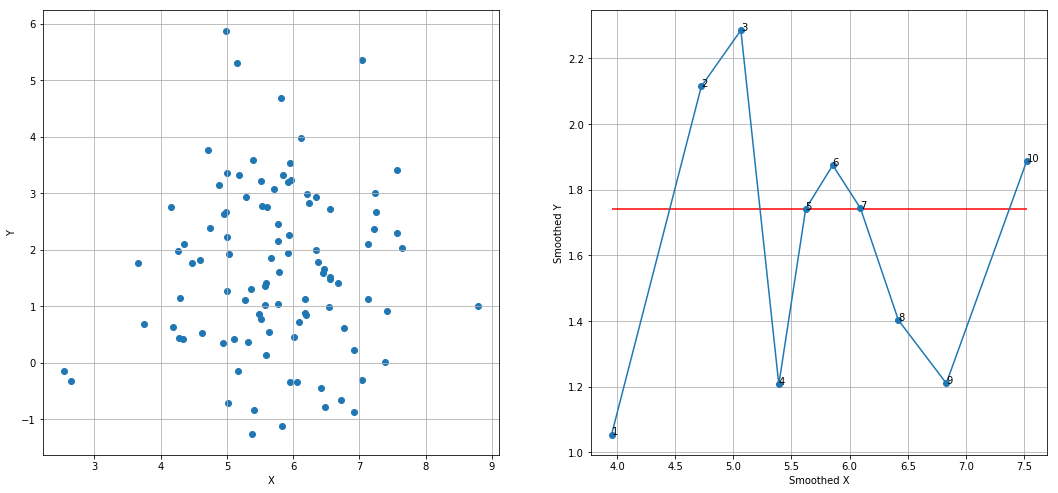

In [3]:
df_raw = pd.read_csv('random_dataset.csv')
df = extract_from_dataset(df_raw, 'X', 'Y')
scatterplots(df, 'X', 'Y', n_slices = 10)

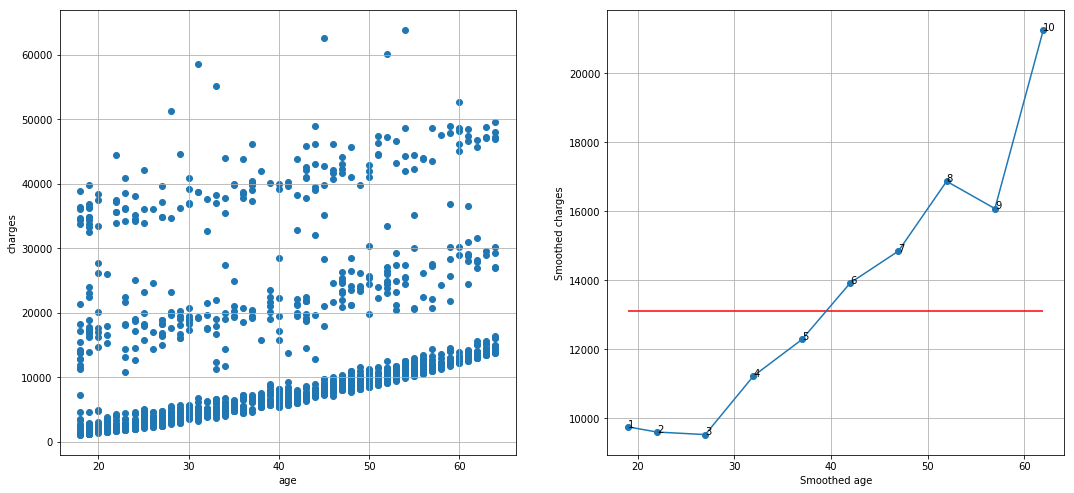

In [4]:
df_raw = pd.read_csv('insurance.csv')
df = extract_from_dataset(df_raw, 'age', 'charges')
scatterplots(df, 'age', 'charges', n_slices = 10)

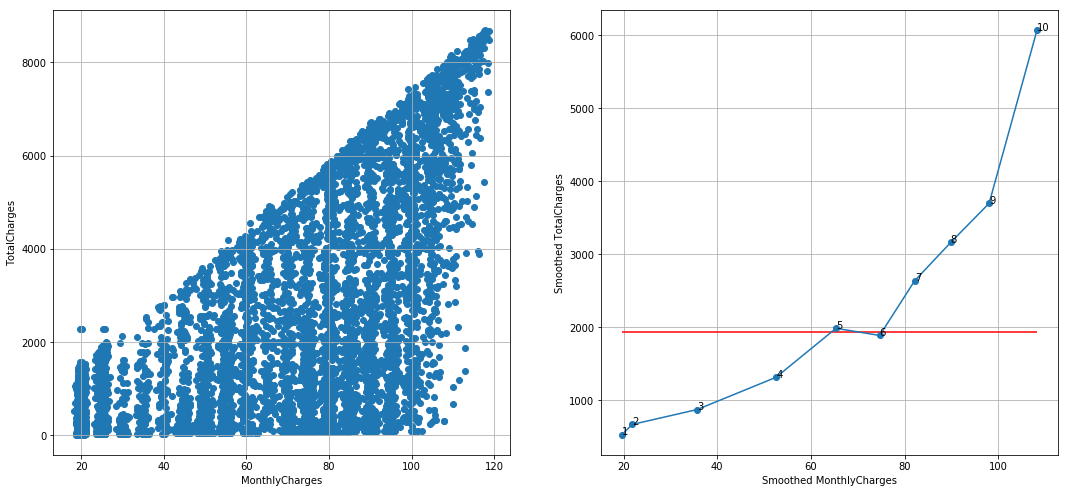

In [5]:
df_raw = pd.read_csv('Telco-Customer-Churn.csv')
df = extract_from_dataset(df_raw, 'MonthlyCharges', 'TotalCharges')
scatterplots(df, 'MonthlyCharges', 'TotalCharges', n_slices = 10)

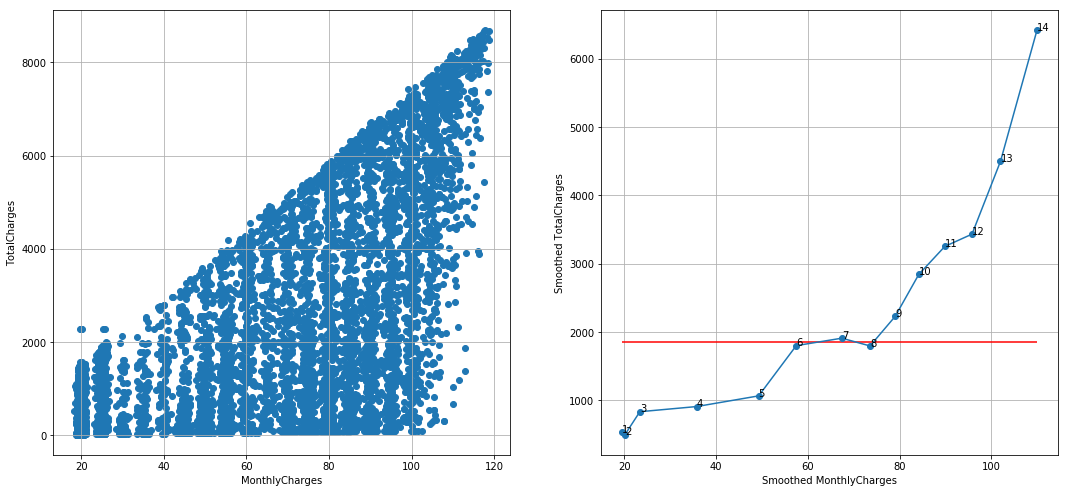

In [6]:
scatterplots(df, 'MonthlyCharges', 'TotalCharges', n_slices = 14)

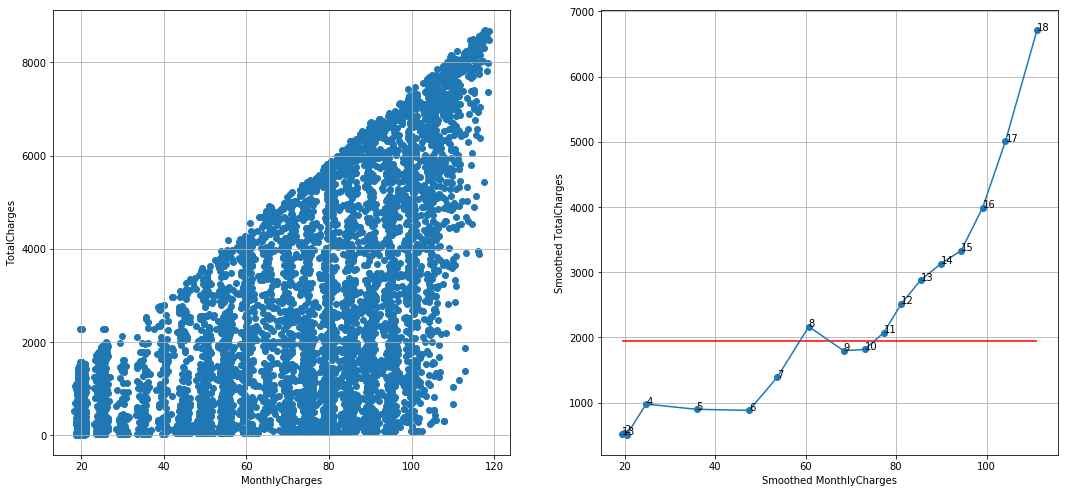

In [7]:
scatterplots(df, 'MonthlyCharges', 'TotalCharges', n_slices = 18)

The table below contains some results of applying GAT procedure to X,Y variables extracted from different datasets.

| dataset | X | Y | N | TS | Cutoff score (95%)| GAT result |
| --- | --- | --- | --- | --- | --- | --- |
| Random | random | random | 10 | 4 | 7 | Failed to reject H0 |
| Insurance | age | charges | 10 | 8 | 7 | Reject H0 |
| Customer churn | Montly Charges | Total Chages | 10 | 6 | 7 | Failed to reject H0 |
| Customer churn | Montly Charges | Total Chages | 14 | 10 | 10 | Reject H0 |
| Customer churn | Montly Charges | Total Chages | 18 | 14 | 12 | Reject H0 |

Customer churn examples reveal the fact that correct N selection in some cases is a trade-off  between small and large N values. Small N value may mask too much noise while large N value  may show unreliable noise – see, for example,  smoothed scatterplot for n_slices = 18 where smoothed points 1, 2, 3 are very close to each other.

**References**

__[1.](https://www.crcpress.com/Statistical-and-Machine-Learning-Data-Mining-Techniques-for-Better-Predictive/Ratner/p/book/9781498797603)__ Ratner, B., *Statistical and Machine-Learning Data Mining*, CRC Press, 2017.